Import all necessary modules

In [1]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import csv

Function Dictionary

In [2]:
# Calculate E(z), which in this situation depends on w
def E(z_i, w, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    E = np.sqrt(omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l * (1.0+z_i)**(3.0*(1.0+w)))
    return E;

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, w, omega_m, omega_l):
    f = lambda z_i: 1.0 / E(z_i, w, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

In [3]:
# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, w, DMDH, omega_m, omega_l):
    # create the output array DMDH
    DMDH = np.copy(z);

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(r"$\Omega_k =$ " + str(omega_k))
    print(r"$\Omega_\Mu =$ " + str(omega_m))
    print(r"$\Omega_\Lambda =$ " + str(omega_l))

    # Calculate D_M/D_H for different universe geometries
    # open universe (omega_k > 0)
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],w,omega_m,omega_l) )
    # closed universe (omega_k < 0)
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],w,omega_m,omega_l) )
    # flat universe (omega_k = 0)
    else:
        DMDH = 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) );

    return DMDH

# proper motion distance for omega_l != 0
def prop_motion(z, w, DMDH, omega_m, omega_l):
    DMDH = np.copy(z);
    
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(omega_k)
    
    # Calculate D_M/D_H for different universe geometries
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],w,omega_m,omega_l) )
    # closed universe
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],w, omega_m,omega_l) )
    # flat universe
    else:
        for i in range(len(z)):
            DMDH[i] = DCDH_int(z[i], w, omega_m, omega_l)
    return DMDH

In [4]:
# angular diameter distance
def dist_angdiam(z, DMDH, DADH, omega_m, omega_l):
    DADH = np.copy(z);
    DADH = DMDH / (1.0+z)
    return DADH;

# luminosity distance
def dist_lum(z, DMDH, DLDH, omega_m, omega_l):
    DLDH = np.copy(z)
    DLDH = DMDH * (1.0+z)
    return DLDH;

# distance modulus
def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    # initialize the distance modulus array
    mu = np.copy(z)

    # convert D_H from Mpc to pc
    D_H = D_H * 1.0e6

    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    return mu;

# comoving volume element
def com_vol(z, DMDH, DVC, omega_m, omega_l, D_H):
    DVC = np.copy(z)
    for i in range(len(z)):
        DVC[i] = DMDH[i]**2 * D_H**3 / ( E(z[i], omega_m, omega_l) )
    return DVC

Variable Dictionary

In [5]:
# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_m = None                  # mass density parameter
w = None                        # equation of state
omega_l = None                  # energy density
pressure = 0.0                  # pressure of the universe

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots
npts = None                     # Number of points (omega_m, w) we use

# Output arrays
z = None;                       # Array of input values of z
DMDH = np.array([])             # Array of output values of D_M/D_H
DADH = np.array([])             # Array of output values of D_A/D_H
DLDH = np.array([])             # Array of output values of D_L/D_H
dmod = np.array([])             # distance modulus array
DVC = np.array([])              # comoving volume array
tLtH = np.array([])             # Array of lookback times
age = np.array([])              # Array of ages
dPdz = np.array([])             # dimensionless intersection probability

We draw arrays of corresponding density parameters from Figure 20.

We note that equation of state $w$ and energy density $\Omega_\Lambda$ are related as follows:
$$w = \frac{pressure}{\Omega_\Lambda}$$

Take in values. Test each value of omega_m and w individually.

In [6]:
# arrays of density parameters

# Take in densities
print("\u03A9_k = 0.0")     # omega_k = 0.0

# Take in Hubble constant
H = 70
D_H = c / H                 # Hubble distance

# Take in w-values and omega_m values
omega_m = float(input("Value of omega_m: "))
w = float(input("Value of w: "))

# Parameters for plot, including the range of redshift values and y-axis
zmin = 0.001
zmax = 2.5
ymin = 0
ymax = 50

# Define the array of z-values (redshift)
z = np.linspace(zmin, zmax, 100)

Ω_k = 0.0
Value of omega_m: 0.5
Value of w: -1.0


Plot the Distance Modulus. Assume a flat universe, i.e. $\Omega_\Lambda = 1 - \Omega_M$.

0.0


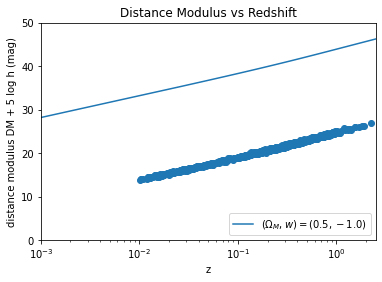

In [7]:
plt.title("Distance Modulus vs Redshift")
plt.xlabel("z")
plt.ylabel("distance modulus DM + 5 log h (mag)")

# Begin by collecting csv data and making a scatter plot of it
sne_x = []
sne_y = []
err_sne_y = []

with open('ps1_data.txt', newline='') as csvfile:
    ps1_data = csv.reader(csvfile, delimiter=' ')
        
    i = 0
    for row in ps1_data:
        if (i > 0):
            sne_x.append(float(row[1]))
            sne_y.append(float(row[4]))
            err_sne_y.append(float(row[5]))
        i+= 1
csvfile.close()

# convert all lists to arrays
sne_x = np.array(sne_x)
sne_y = np.array(sne_y)
err_sne_y = np.array(err_sne_y)

# Generate scatterplot
plt.scatter(sne_x, sne_y)

# Calculate the distance moduli and plot them
omega_l = 1.0 - omega_m
if (omega_l == 0):
    DMDH = prop_motion_0(z, w, DMDH, omega_m, omega_l)
else:
    DMDH = prop_motion(z, w, DMDH, omega_m, omega_l)

mu = dist_mod(z, D_H, omega_m, omega_l, DMDH)

param_text = r"$\left(\Omega_M, w\right) = " + "(" + str(omega_m) + ", " + str(w) + ")$"
plt.plot(z, mu, label=param_text)

# Plot attributes
plt.axis([zmin, zmax, ymin, ymax])
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

Generate a residual plot by feeding values from sne_x into the prop_motion() function.

0.0


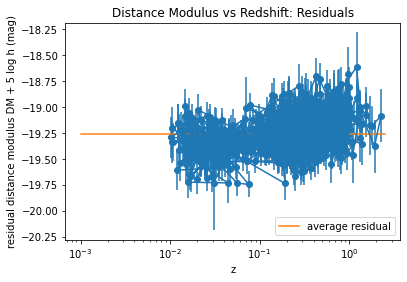

In [8]:
res = []                     # list of residuals

# test values of omega_m and omega_l

# Feed the sne_x array into the functions
if (omega_l == 0):
    DMDH = prop_motion_0(sne_x, w, DMDH, omega_m, omega_l)
else:
    DMDH = prop_motion(sne_x, w, DMDH, omega_m, omega_l)

# corresponding predicted distance modulus
dm_predicted = dist_mod(sne_x, D_H, omega_m, omega_l, DMDH)

# actual distance modulus
dm_actual = np.copy(sne_y)

# calculate residuals and convert to array
res = dm_actual - dm_predicted
res = np.array(res)

# Find the average residual value
avg_res = np.mean(res)
# Plot a horizontal line corresponding to y = avg_res
avg_y = np.copy(z)    # Create a copy of the z-array into the avg_y array
for i in range(len(avg_y)):    # Assign each slot of avg_y the value avg_res
    avg_y[i] = avg_res

# re-calculate the error bars for residuals if needed
# sigma_res = sqrt(sigma_dm_actual^2 + sigma_dm_predicted^2)
err_predicted = 0.0    # assume zero uncertainty in the prediction function
sigma_res = np.array([])
sigma_res = err_sne_y**2 + err_predicted**2
sigma_res = np.sqrt(sigma_res)

param_text = "average residual"
    
plt.title("Distance Modulus vs Redshift: Residuals")
plt.xlabel("z")
plt.ylabel("residual distance modulus DM + 5 log h (mag)")
plt.scatter(sne_x, res)
plt.errorbar(sne_x, res, yerr=sigma_res)
plt.plot(z, avg_y, label=param_text)
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

Plot again with residuals concentrated around 0.

No handles with labels found to put in legend.


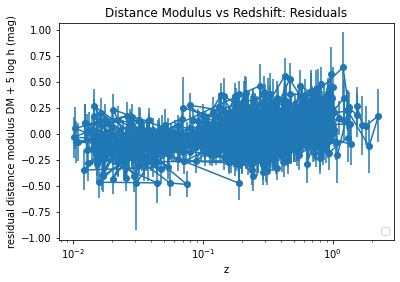

In [9]:
param_text = r"$\left(\Omega_M, w\right) = " + "(" + str(omega_m) + ", " + str(w) + ")$"
    
plt.title("Distance Modulus vs Redshift: Residuals")
plt.xlabel("z")
plt.ylabel("residual distance modulus DM + 5 log h (mag)")
plt.scatter(sne_x, res-avg_res)
plt.errorbar(sne_x, res-avg_res, yerr=sigma_res)
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

Let's plot the scatterplot lined up with the function graph:

0.0


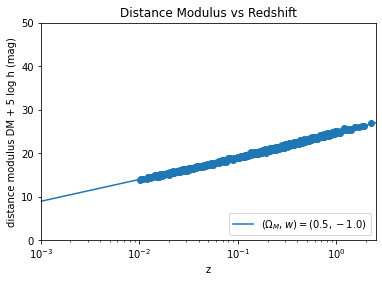

[0.50309 0.4948  0.67767 ... 1.014   1.315   1.092  ]
1048


In [10]:
if (omega_l == 0):
    DMDH = prop_motion_0(z, w, DMDH, omega_m, omega_l)
else:
    DMDH = prop_motion(z, w, DMDH, omega_m, omega_l)

mu = dist_mod(z, D_H, omega_m, omega_l, DMDH) + avg_res

plt.title("Distance Modulus vs Redshift")
plt.xlabel("z")
plt.ylabel("distance modulus DM + 5 log h (mag)")
param_text = r"$\left(\Omega_M, w\right) = " + "(" + str(omega_m) + ", " + str(w) + ")$"
plt.plot(z, mu, label=param_text)
plt.scatter(sne_x, sne_y)
plt.axis([zmin, zmax, ymin, ymax])
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

print(sne_x)
print(len(sne_x))

Now let's bin the z-values into bins of equal size and find the average residual for each bin.

Enter number of bins of z: 20
number of bins: 20
bin size: 52.4
[0.05624699999999999, 0.16874099999999997, 0.28123499999999996, 0.39372899999999994, 0.5062229999999999, 0.6187169999999999, 0.7312109999999998, 0.8437049999999998, 0.9561989999999998, 1.0686929999999997, 1.1811869999999995, 1.2936809999999994, 1.4061749999999993, 1.5186689999999992, 1.631162999999999, 1.743656999999999, 1.8561509999999988, 1.9686449999999986, 2.0811389999999985, 2.1936329999999984]
[-19.2520359222649, -19.257966580980153, -19.2485154936023, -19.251458188229577, -19.242989486811513, -19.2303124863229, -19.278458125036636, -19.272366425898607, -19.262278445828063, -19.258899387991175, -19.241029460258808, -19.219335246454484, -19.207113718042816, -19.262966750267708, -19.234625955674346, -19.249420727142542, -19.35092267931773, -19.357210559518144, -19.329109722157362, -19.26969525515193]


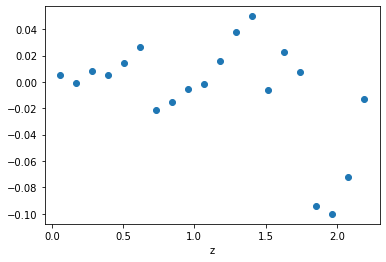

In [13]:
#Create copies of sne_x, res, sigma_res
zs = np.copy(sne_x)    # z-values
# res and sigma_res already exist
zs, res, sigma_res = zip(*sorted(zip(zs, res, sigma_res)))

Nbins = int(input("Enter number of bins of z: "))   # Number of bins
bin_size = (1.0*len(sne_x)) / (1.0* Nbins)    # bin size (in terms of number of array slots)
j = 0                                               # index of each entry in the full sne_x array
Nadded = 0                                          # number of residuals added from the current bin
binned_z = []                                       # array of average z-values per bin
zstep = (max(sne_x)-min(sne_x)) / (1.0*Nbins)       # z-step = range / Nbins
cur_z = -zstep / 2.0                                # current average value of z for the bin
bin_mean = 0.0                                      # average residual for the given bin
bin_means = []                                      # average residuals for bins, in an array
bin_mean_se = 0.0                                   # standard error of the current bin
bin_mean_ses = []                                   # array of standard errors of bins
sum_wj_rj = 0.0                                     # sum of: (weight times residual)
sum_wj = 0.0                                        # sum of weights

print("number of bins: " + str(Nbins))
print("bin size: " + str(bin_size))

# iterate over all bins, calculate average residual for each bin

for i in range(Nbins):
    cur_z += zstep                      # increment the current average binned z value
    
    wj = 0.0           # weight
    rj = 0.0           # residual
    
    # Inside the current bin, sum the residuals
    while (j < math.ceil((i+1)*bin_size) and j < len(res)): # Inside the current bin, sum the residuals
        rj = res[j]
        wj = 1.0/sigma_res[j]
        sum_wj_rj += wj * rj
        sum_wj += wj
        j+=1
            
    bin_mean = sum_wj_rj / sum_wj    # calcualte average residual for given bin and add to array
    bin_means.append(bin_mean)
    
    # calculate standard error for given bin and append to array of SE's
    bin_mean_se = 1.0/np.sqrt(sum_wj)
    bin_mean_ses.append(bin_mean_se)
    
    # Append the current z-value to array of binned z-values
    binned_z.append(cur_z)
    
    # reset incremental values to 0
    sum_wj_rj = 0.0
    sum_wj = 0.0
    bin_mean = 0.0                      # reset bin mean residual to 0
    bin_mean_se = 0.0                   # reset bin standard error to 0

    i+=1                                # increment i
    
print(binned_z)
print(bin_means)

# Plot residuals
plt.xlabel("z")
plt.ylabel("")
plt.scatter(binned_z, bin_means-avg_res)
plt.show()

Let's superimpose the binned residuals on top of our original residual scatterplot.

No handles with labels found to put in legend.


length of original arrays
1048
1048
length of binned arrays
20
20


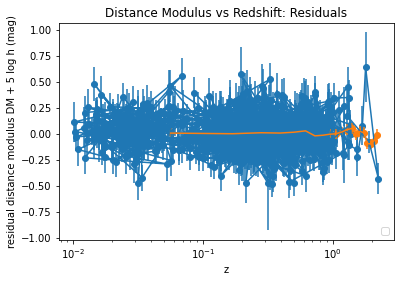

In [14]:
print("length of original arrays")
print(len(sne_x))
print(len(res))
print("length of binned arrays")
print(len(binned_z))
print(len(bin_means))

param_text = r"$\left(\Omega_M, w\right) = " + "(" + str(omega_m) + ", " + str(w) + ")$"
    
plt.title("Distance Modulus vs Redshift: Residuals")
plt.xlabel("z")
plt.ylabel("residual distance modulus DM + 5 log h (mag)")

# Original residuals
plt.scatter(sne_x, res-avg_res)
plt.errorbar(sne_x, res-avg_res, yerr=sigma_res)

# Binned residuals
plt.scatter(binned_z, bin_means-avg_res)
plt.errorbar(binned_z, bin_means-avg_res, yerr=bin_mean_ses)
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

Plot again, this time making the cosmology plot match the scatterplot:

0.0


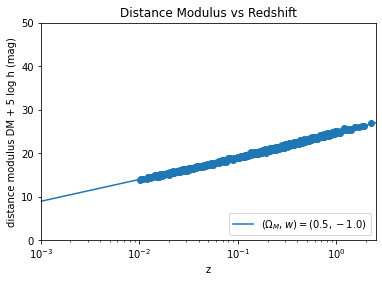

[22.93445 22.8802  24.0377  ... 24.85445 25.54235 24.63835]
1048


In [15]:
if (omega_l == 0):
    DMDH = prop_motion_0(z, w, DMDH, omega_m, omega_l)
else:
    DMDH = prop_motion(z, w, DMDH, omega_m, omega_l)

mu = dist_mod(z, D_H, omega_m, omega_l, DMDH) + avg_res

plt.title("Distance Modulus vs Redshift")
plt.xlabel("z")
plt.ylabel("distance modulus DM + 5 log h (mag)")
param_text = r"$\left(\Omega_M, w\right) = " + "(" + str(omega_m) + ", " + str(w) + ")$"
plt.plot(z, mu, label=param_text)
plt.scatter(sne_x, sne_y)
plt.axis([zmin, zmax, ymin, ymax])
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()
print(sne_y)
print(len(sne_y))

Examples of good data points $(\Omega_M, w)$:

(0.2,-0.8)

(0.3,-1.0)

(0.4,-1.3)

Examples of bad data points $(\Omega_M, w)$:

(0.5, -1.0)

(0.25, -0.2)

(0.3, -2.0)

(0.1, -1.5)